In [1]:
#| default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
from fastcore.test import test_close
from urllib.request import urlretrieve

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Initial Setup

## Data

In [4]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, 10)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)
preds = model(x_train)
preds.shape

torch.Size([50000, 10])

## Cross-Entropy Loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [7]:
def log_softmax(x): return x - x.exp().sum(dim=1, keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [8]:
x_train.max(-1)[0].shape, x_train.shape

(torch.Size([50000]), torch.Size([50000, 784]))

In [9]:
def logsumexp(x):
    m = x.max(1)[0]
    m + (x-m[:, None]).exp().sum(dim=1).log()

In [10]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [11]:
sm_preds = log_softmax(preds)
sm_preds

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [12]:
y_train[:3]

tensor([5, 0, 4])

In [13]:
sm_preds[0, 5], sm_preds[1, 0], sm_preds[2, 4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [14]:
sm_preds[[0, 1, 2], [5, 0, 4]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [15]:
def nll_loss(preds, targ): return -preds[range(targ.shape[0]), targ].mean()

In [16]:
loss = nll_loss(sm_preds, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [17]:
test_close(F.nll_loss(F.log_softmax(preds, -1), y_train), loss, 1e-3)

In [18]:
test_close(F.cross_entropy(preds, y_train), loss, 1e-3)

# Basic Training Loop

The training loop repeats over the following steps:
- Get the model output over a batch of input
- Compare the output with actual labels to compute the loss
- Calculate the gradients of the loss wrt to all the model parameters
- Update the said parameters with the above loss to make them a little better. 

In [19]:
#|export
def accuracy(preds, targ): return (preds.argmax(dim=1, keepdim=False) == targ).float().mean()

In [20]:
#| export
def report(loss, preds, yb): print(f'loss: {loss:.2f}, accuracy: {accuracy(preds, yb):.2f}')

In [21]:
epochs = 5
bs = 64
lr = 0.5
loss_func = F.cross_entropy

for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

loss: 0.19, accuracy: 0.94
loss: 0.05, accuracy: 1.00
loss: 0.03, accuracy: 1.00
loss: 0.03, accuracy: 1.00
loss: 0.06, accuracy: 1.00


# Using parameters and optim

## Parameters

In [22]:
m1 = nn.Module()
m1.lin = nn.Linear(m, nh)
m1

Module(
  (lin): Linear(in_features=784, out_features=50, bias=True)
)

In [23]:
list(m1.named_children())

[('lin', Linear(in_features=784, out_features=50, bias=True))]

In [24]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.04,  0.03, -0.02,  ...,  0.03,  0.03,  0.00],
         [ 0.04,  0.01,  0.03,  ..., -0.01,  0.02,  0.03],
         [ 0.03,  0.03, -0.01,  ...,  0.01, -0.01,  0.00],
         ...,
         [-0.01, -0.02, -0.03,  ..., -0.01,  0.00, -0.00],
         [-0.01, -0.02,  0.00,  ...,  0.00,  0.01, -0.01],
         [ 0.03,  0.02, -0.02,  ..., -0.01, -0.01, -0.04]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.01, -0.00,  0.01, -0.03,  0.02, -0.03,  0.01, -0.01, -0.00,  0.03, -0.02, -0.01, -0.02,  0.00,  0.03, -0.04,  0.01, -0.00,
         -0.02, -0.01, -0.02,  0.03,  0.02, -0.01,  0.02, -0.02, -0.02, -0.00, -0.02, -0.01, -0.01,  0.02,  0.01,  0.03,  0.03,  0.02, -0.02,
          0.02, -0.00,  0.01, -0.03,  0.03,  0.01,  0.03, -0.01,  0.02, -0.01,  0.03,  0.00], requires_grad=True)]

In [25]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.l2(self.relu((self.l1(x))))

In [26]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [27]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [28]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [29]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [30]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [31]:
fit()

loss: 0.29, accuracy: 0.88
loss: 0.18, accuracy: 0.88
loss: 0.09, accuracy: 0.94
loss: 0.04, accuracy: 1.00
loss: 0.05, accuracy: 1.00


Behind the scenes PyTorch rewrites the `__setattr__` method in `nn.Module` so that the submodules we define are properly registered as parameters of the model.

In [32]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()

    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)

    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [33]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True), 'relu': ReLU()}

In [34]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering Modules

In [35]:
from functools import reduce

In [36]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [37]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x)

In [38]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [39]:
xb, yb = x_train[:bs], y_train[:bs]

In [40]:
model(xb).shape

torch.Size([64, 10])

## nn.ModuleList

In [41]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [42]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [43]:
fit()

loss: 0.40, accuracy: 0.94
loss: 0.16, accuracy: 0.94
loss: 0.12, accuracy: 1.00
loss: 0.09, accuracy: 1.00
loss: 0.07, accuracy: 1.00


## nn.Sequential

In [44]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [45]:
fit()

loss: 0.17, accuracy: 0.88
loss: 0.07, accuracy: 1.00
loss: 0.04, accuracy: 1.00
loss: 0.03, accuracy: 1.00
loss: 0.02, accuracy: 1.00


# optim

In [46]:
class Optimizer():
    def __init__(self, params, lr=0.2): self.params, self.lr = list(params), lr
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [47]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [48]:
opt = Optimizer(model.parameters())

In [49]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.27, accuracy: 0.94
loss: 0.13, accuracy: 1.00
loss: 0.08, accuracy: 1.00
loss: 0.05, accuracy: 1.00
loss: 0.05, accuracy: 1.00


In [50]:
from torch import optim

In [51]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [52]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [53]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.21, accuracy: 0.94
loss: 0.14, accuracy: 0.94
loss: 0.11, accuracy: 1.00
loss: 0.16, accuracy: 1.00
loss: 0.08, accuracy: 1.00


# Dataset and DataLoader

## Dataset

In [54]:
#|export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [55]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [56]:
xb, yb = train_ds[:5]
assert xb.shape == (5, 784)
assert yb.shape == (5, )
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [57]:
model, opt = get_model()

In [58]:
for epoch in range(epochs):
    for i in range(0, n, bs):
    #for xb, yb in train_dl:
        xb, yb = train_ds[i:min(n, i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.25, accuracy: 0.94
loss: 0.07, accuracy: 1.00
loss: 0.06, accuracy: 1.00
loss: 0.04, accuracy: 1.00
loss: 0.03, accuracy: 1.00


## DataLoader

In [59]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+bs]

In [60]:
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

In [61]:
xb, yb = next(iter(valid_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

tensor(3)

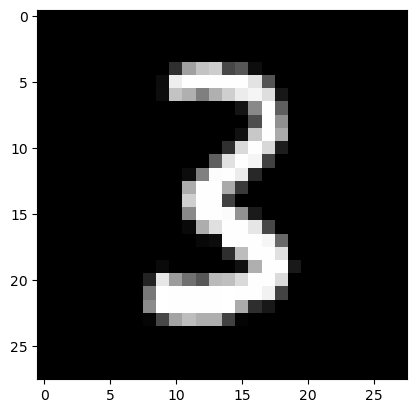

In [62]:
plt.imshow(xb[0].view(28, 28));
yb[0]

In [63]:
model, opt = get_model()

In [64]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [65]:
fit()

loss: 0.23, accuracy: 0.94
loss: 0.15, accuracy: 0.94
loss: 0.10, accuracy: 1.00
loss: 0.07, accuracy: 1.00
loss: 0.04, accuracy: 1.00


## Random Sampling

In [66]:
import random

In [67]:
class Sampler:
    def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [68]:
from itertools import islice

In [69]:
ss = Sampler(train_ds)

In [70]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [71]:
list(islice(it, 5))

[5, 6, 7, 8, 9]

In [72]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[38989, 42498, 7068, 2533, 10884]

In [73]:
import fastcore.all as fc

In [74]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [75]:
batches = BatchSampler(ss, 5)
list(islice(batches, 5))

[[46762, 34179, 4449, 28163, 9950],
 [49868, 49121, 42587, 10922, 4640],
 [3333, 9443, 20612, 14952, 22725],
 [28773, 11116, 15013, 31204, 29907],
 [48345, 6423, 7881, 39680, 9204]]

In [76]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [77]:
class DataLoader():
    def __init__(self, ds, batches, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batches)

In [78]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [79]:
train_dl = DataLoader(train_ds, batches=train_samp)
valid_dl = DataLoader(valid_ds, batches=valid_samp)

tensor(3)

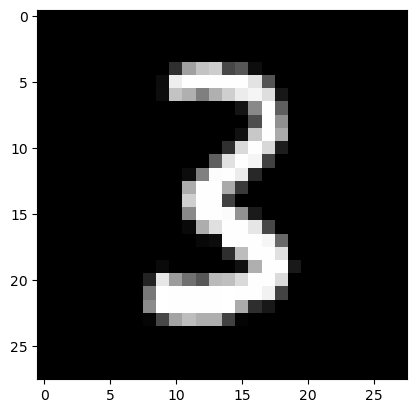

In [80]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [81]:
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [82]:
model, opt = get_model()

In [83]:
fit()

loss: 0.22, accuracy: 0.88
loss: 0.02, accuracy: 1.00
loss: 0.13, accuracy: 0.94
loss: 0.11, accuracy: 0.94
loss: 0.18, accuracy: 0.88


## Multiprocessing DataLoader

In [84]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [85]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [86]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [87]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [88]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [89]:
train_dl = DataLoader(train_ds, batchs=train_samp)
it = iter(train_dl)

## PyTorch DataLoader

In [90]:
#|export
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, SequentialSampler

In [91]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False) 

In [92]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [93]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

loss: 0.36, accuracy: 0.88
loss: 0.30, accuracy: 0.94
loss: 0.20, accuracy: 0.88
loss: 0.03, accuracy: 1.00
loss: 0.00, accuracy: 1.00


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

PyTorch can also generate batch sampler and sequential/batch samplers.

In [94]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [95]:
model, opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

loss: 0.13, accuracy: 0.98
loss: 0.09, accuracy: 0.95
loss: 0.11, accuracy: 0.97
loss: 0.10, accuracy: 0.98
loss: 0.06, accuracy: 0.95


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset already knows how to sample a batch of inputs all at once:

In [96]:
train_ds[[3, 4, 6]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 9, 1]))

In [97]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [98]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

# Validation

In [99]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            total_loss, total_acc, count = 0., 0., 0
            for xb, yb in valid_dl:
                n = len(xb)
                count += n
                preds = model(xb)
                total_loss += loss_func(preds, yb).item()*n
                total_acc += accuracy(preds, yb).item()*n
            print(f'epoch:{epoch}, loss:{total_loss/count}, accuracy:{total_acc/count}')
    return total_loss, total_acc

In [100]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
           DataLoader(valid_ds, batch_size=bs, **kwargs))

In [101]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

In [102]:
%time loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

epoch:0, loss:0.15740505851209163, accuracy:0.9565
epoch:1, loss:0.13495875933617354, accuracy:0.9606
epoch:2, loss:0.12014229471236468, accuracy:0.966
epoch:3, loss:0.17350975091159343, accuracy:0.9481
epoch:4, loss:0.10858670871444047, accuracy:0.9702
CPU times: user 21.4 s, sys: 36.9 ms, total: 21.4 s
Wall time: 5.37 s


# Export

In [103]:
import nbdev; nbdev.nbdev_export()

InterpolationMissingOptionError: Bad value substitution: option 'lib_name' in section 'DEFAULT' contains an interpolation key 'repo' which is not a valid option name. Raw value: '%(repo)s'